In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 22/06/2022

    Code description :
    __________________
    Show the restriction operator and its adjoint being the zero-padding, and 
    illustrates why the multiplicity correction is necessary.
"""
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),1),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
set_plot_params() # Set the plot params

We consider a 1D space and start by selecting random core positions in $[0,N/2]$. <br>
This way $\Omega$ remains in [$-N/2,N/2$] and there is no aliasing. <br>
Some pairwise differences between core positions appear multiple times. Their multiplicities
are shown.

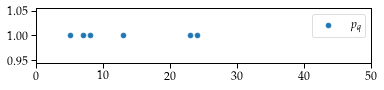

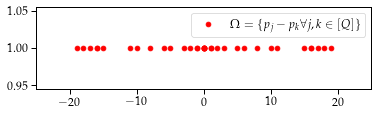

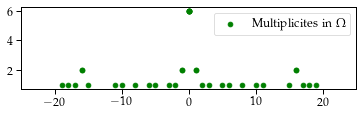

In [2]:
Q = 6 # Number of cores
N = 50

pos_cores = np.random.permutation(np.arange(int(N/2)))[:Q] # random cores locations (/!\ Indices)
"Define Om = {p_j - p_k, j,k \in [Q]}"
Om = np.subtract.outer(pos_cores, pos_cores).astype(int)
"Compute the multiplicity of each frequency"
multiplicities = ind_multiplicity_1D(Om)

plt.figure(figsize=(6,1))
plt.scatter(pos_cores, np.ones(Q), label=r'$p_q$')
plt.xlim([0,N])
plt.legend()
plt.show()

plt.figure(figsize=(6,1.5))
plt.scatter(Om, np.ones(Q**2), c='r', label=r'$\Omega=\{p_j-p_k \forall j,k \in [Q]\}$')
plt.xlim([-N/2,N/2])
plt.legend()
plt.show()

plt.figure(figsize=(6,1.5))
plt.scatter(Om, np.ones(Q**2)*multiplicities.reshape(-1), c='g', label=r'Multiplicites in $\Omega$')
plt.xlim([-N/2,N/2])
plt.legend()
plt.show()

For a toy example $\boldsymbol x \in \mathbb Z^{50}$, shows its restriction to the set 
$\Omega$, i.e. $\boldsymbol R_\Omega (\boldsymbol x)$. <br>
Because of the multiplicity of some indices, we see there is a bias. 

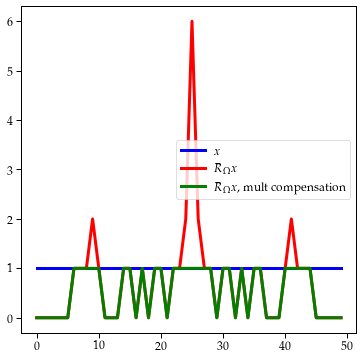

In [3]:
x = np.ones(N)
STSx = S_Om_star_1D(S_Om_1D(x, Om), Om, x.shape)
STSx2 = S_Om_star_1D(S_Om_1D(x, Om, multiplicities), Om, x.shape, multiplicities)

plt.figure()
plt.plot(x,'b', label=r'$x$')
plt.plot(np.fft.fftshift(np.real(STSx)),'r', label=r'$R_\Omega x$')
plt.plot(np.fft.fftshift(np.real(STSx2)),'g', label=r'$R_\Omega x$, mult compensation')
plt.legend()
plt.show()

If the cores positions $p_q$ exceed $N/2$, the pairwise differences in positions $\Omega$ will exceed
$[-N/2,N/2]$, hence $[0,N-1]$. <br>
Thus, because of Python convention, these indices will wrap up to first values. There is 
aliasing. <br>

Note that in practice the core positions that exceed the band of the sample $f$ will simply not contribute to the observation as they yield 0. See the derivations about discretisation in the notes. 

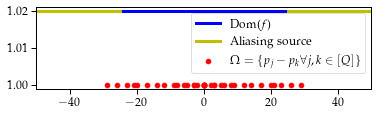

In [4]:
pos_cores_excess = np.random.permutation(np.arange(N))[:Q] # random cores locations (/!\ Indices)
"Define Om = {p_j - p_k, j,k \in [Q]}"
Om_excess = np.subtract.outer(pos_cores_excess, pos_cores_excess).astype(int)
"Compute the multiplicity of each frequency"
multiplicities_excess = ind_multiplicity_1D(Om_excess)

plt.figure(figsize=(6,1.5))
plt.scatter(Om_excess, np.ones(Q**2), c='r', label=r'$\Omega=\{p_j-p_k \forall j,k \in [Q]\}$')
plt.xlim([-N,N])
plt.plot([-N/2,N/2],[1.02,1.02],'b', label=r'Dom($f$)')
plt.plot([-N,-N/2],[1.02,1.02],'y', label=r'Aliasing source')
plt.legend()
plt.plot([N/2,N],[1.02,1.02],'y', label=r'Aliasing source')
plt.show()

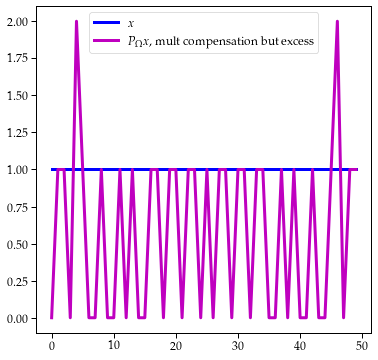

In [5]:
STSx3 = S_Om_star_1D(S_Om_1D(x, Om_excess, multiplicities_excess), \
    Om_excess, x.shape, multiplicities_excess)

plt.figure()
plt.plot(x,'b', label=r'$x$')
plt.plot(np.fft.fftshift(np.real(STSx3)),'m', label=r'$P_\Omega x$, mult compensation but excess')
plt.legend()
plt.show()

One way to circumvent this issue is to zero the indices in $\Omega$ exceeding $N$.

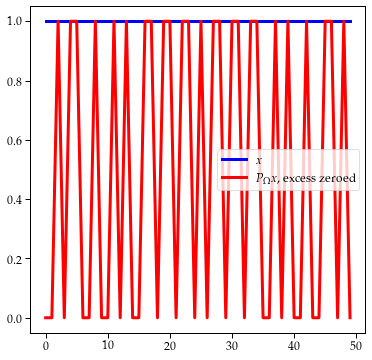

In [6]:
Om_excess_cancelled = Om_excess[np.abs(Om_excess)<N/2]

"Compute the multiplicity of each frequency"
multiplicities_excess_cancelled = ind_multiplicity_1D(Om_excess_cancelled)

STSx4 = S_Om_star_1D(S_Om_1D(x, Om_excess_cancelled, multiplicities_excess_cancelled), \
    Om_excess_cancelled, x.shape, multiplicities_excess_cancelled)

plt.figure()
plt.plot(x,'b', label=r'$x$')
plt.plot(np.fft.fftshift(np.real(STSx4)),'r', label=r'$P_\Omega x$, excess zeroed')
plt.legend()
plt.show()

Another way, less clean would be to take the pairwise differences modulo $N$.
However, this would still keep some samples inside the object $f$ than should be outside
of the domain of $f$.

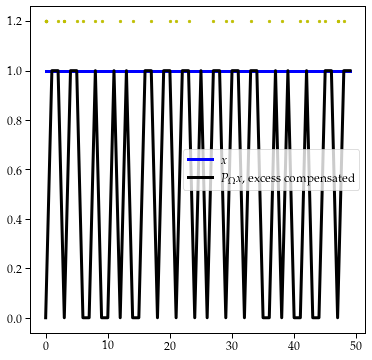

In [7]:
"Compute the multiplicity of each frequency"
multiplicities_excess2 = ind_multiplicity_1D(Om_excess%N)

STSx5 = S_Om_star_1D(S_Om_1D(x, Om_excess, multiplicities_excess2), \
    Om_excess, x.shape, multiplicities_excess2)

plt.figure()
plt.plot(x,'b', label=r'$x$')
plt.plot(np.fft.fftshift(np.real(STSx5)),'k', label=r'$P_\Omega x$, excess compensated')
plt.legend()
vec = Om_excess[np.abs(Om_excess)<N/2]%N
plt.scatter(vec, np.ones(len(vec))+0.2, c='y', marker='.' )
plt.show()